In [1]:

# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, kstest, shapiro
from scipy.optimize import minimize

# For nicer printing
from pprint import pprint



In [20]:
# --- Configuration ---
MAT_PATH = "/Users/madhavs/Downloads/JT_RT.mat"

# Selection params (match MATLAB defaults)
EXPRESS_CUTOFF = 0.18   # seconds; use your expressCutoff(1)
RT_MAX = 1.2            # seconds

# --- Loader & helpers ---
import numpy as np
from scipy.io import loadmat

def _as_1d_float(x):
    v = np.asarray(x).squeeze().ravel().astype(float)
    return v[np.isfinite(v)]

def _extract_field(md, *names, required=True):
    """
    Grab the first present variable from 'names'.
    Example: _extract_field(md, 'tRxnSum', 't_rxn', 'RT')
    """
    for nm in names:
        if nm in md:
            return _as_1d_float(md[nm])
    if required:
        raise KeyError(f"None of the expected variables were found: {names}. "
                       f"Available keys: {[k for k in md.keys() if not k.startswith('__')]}")
    return None

def load_later_groups_from_mat(path, express_cutoff=0.18, rt_max=1.2):
    """
    Replicates the MATLAB selection & grouping:
      Ltrials = (percorrSum==1) & (tRxnSum > express_cutoff) & (tRxnSum < rt_max)
      Groups:
        1) Left,  CP     (numdirSum==-1 & labelSum==1)
        2) Left,  non-CP (numdirSum==-1 & labelSum~=1)
        3) Right, CP     (numdirSum== 1 & labelSum==1)
        4) Right, non-CP (numdirSum== 1 & labelSum~=1)
    Returns dict(label -> RT array) and the mask dictionary.
    """
    md = loadmat(path, squeeze_me=True, struct_as_record=False)

    # Try common names; adjust if your .mat uses different names.
    tRxnSum    = _extract_field(md, 'tRxnSum', 'RTs', 'rt', 'RT')
    percorrSum = _extract_field(md, 'percorrSum', 'correct', 'isCorrect', 'corr', 'Corr')
    numdirSum  = _extract_field(md, 'numdirSum', 'choiceDir', 'choice', 'dir', 'Dir')
    labelSum   = _extract_field(md, 'labelSum', 'label', 'Label', 'CP', 'cp')

    # Ensure same length
    n = min(map(len, (tRxnSum, percorrSum, numdirSum, labelSum)))
    tRxnSum, percorrSum, numdirSum, labelSum = \
        tRxnSum[:n], percorrSum[:n], numdirSum[:n], labelSum[:n]

    # Build Ltrials mask
    Ltrials = (percorrSum == 1) & (tRxnSum > express_cutoff) & (tRxnSum < rt_max)

    # Masks for direction & CP
    left   = (numdirSum == -1)
    right  = (numdirSum ==  1)
    is_cp  = (labelSum == 1)
    not_cp = (labelSum != 1)

    groups = {
        "Left Choice, CP"     : tRxnSum[Ltrials & left  & is_cp],
        "Left Choice, No CP"  : tRxnSum[Ltrials & left  & not_cp],
        "Right Choice, CP"    : tRxnSum[Ltrials & right & is_cp],
        "Right Choice, No CP" : tRxnSum[Ltrials & right & not_cp],
    }

    # Basic counts (helpful sanity check)
    counts = {k: int(v.size) for k, v in groups.items()}
    total_kept = int(Ltrials.sum())
    return groups, dict(total_kept=total_kept, counts=counts)

# --- Use it ---
groups, info = load_later_groups_from_mat(MAT_PATH, express_cutoff=EXPRESS_CUTOFF, rt_max=RT_MAX)
print("Trials kept:", info["total_kept"])
for k, v in info["counts"].items():
    print(f"{k}: {v} trials")

# If you want a single concatenated vector of RTs (like the MATLAB code sometimes does):
RTs = np.concatenate([groups[k] for k in ["Left Choice, CP", "Left Choice, No CP",
                                          "Right Choice, CP", "Right Choice, No CP"]])
RTs = RTs[np.isfinite(RTs) & (RTs > 0)]
print("Total RTs after grouping:", RTs.size)

Trials kept: 3409
Left Choice, CP: 1285 trials
Left Choice, No CP: 661 trials
Right Choice, CP: 1269 trials
Right Choice, No CP: 194 trials
Total RTs after grouping: 3409


In [21]:
print(RTs)

[0.486722 0.447101 0.461715 ... 0.381572 0.517073 0.558463]


In [25]:

R = 1.0 / RTs
print(f"R size: {R.size}, mean={R.mean():.3f}, std={R.std(ddof=1):.3f}")


R size: 3409, mean=2.761, std=0.808


Compute the reciprocal (R = 1/RT), which is Gaussian under LATER.


Text(0, 0.5, 'Count')

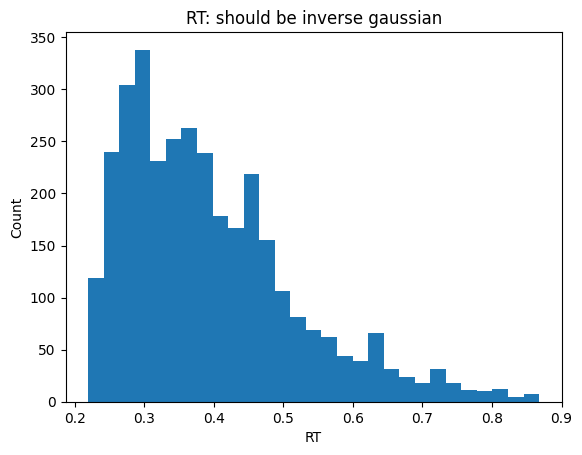

In [30]:
bins = np.linspace(np.percentile(RTs, 1), np.percentile(RTs, 99), 30)
plt.hist(RTs, bins)
plt.title("RT: should be inverse gaussian")
plt.xlabel("RT")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

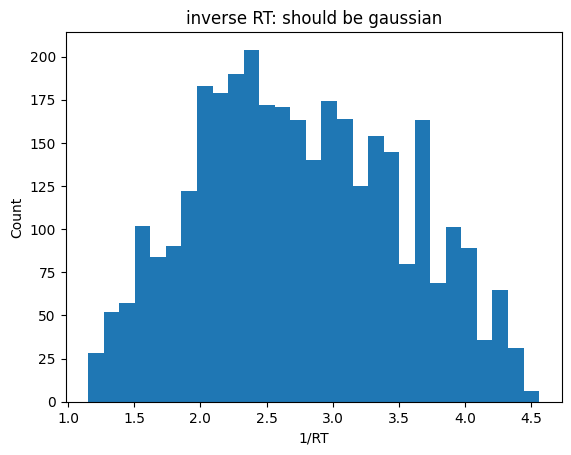

In [29]:
bins = np.linspace(np.percentile(R, 1), np.percentile(R, 99), 30)
plt.hist(R, bins)
plt.title("inverse RT: should be gaussian")
plt.xlabel("1/RT")
plt.ylabel("Count")

In [ ]:
# Objective function??
# This function measures how unlikely your observed data is under a given pair of parameters:

def nll_later(params, R):
    muR, deltaS = params
    return -np.sum(norm.logpdf(R, loc=muR, scale=deltaS))

In [32]:
import numpy as np

# Define parameter bounds
lower_bounds = np.array([0.001, 0.001])
upper_bounds = np.array([1000, 1000])


# Define initial guesses based on empirical mean and std of reciprocal RTs
initial_values = np.array([
    np.mean(R),
    np.std(R, ddof=1)  # ddof=1 for sample std (like MATLAB)
])

print("Lower bounds:", lower_bounds)
print("Upper bounds:", upper_bounds)
print("Initial values [muR, deltaS]:", initial_values)

Lower bounds: [0.001 0.001]
Upper bounds: [1000 1000]
Initial values [muR, deltaS]: [2.76127781 0.80821149]


In [33]:
import numpy as np
from scipy.optimize import minimize, Bounds

# Assume nll_later(params, R) and initial_values, lower_bounds, upper_bounds are defined
R = 1.0 / RTs  # reciprocal RTs

# Set up bounds
bounds = Bounds(lower_bounds, upper_bounds)

# Number of random restarts (like GlobalSearch)
n_restarts = 50

best_nll = np.inf
best_params = None

for i in range(n_restarts):
    # Random initial point within bounds
    x0 = np.array([
        np.random.uniform(lower_bounds[0], upper_bounds[0]),
        np.random.uniform(lower_bounds[1], upper_bounds[1])
    ])
    
    res = minimize(
        nll_later,
        x0=x0,
        args=(R,),
        method='L-BFGS-B',     # good bounded optimizer
        bounds=bounds,
        options={'maxiter': 3000}
    )
    
    if res.fun < best_nll:
        best_nll = res.fun
        best_params = res.x

print("Best-fit parameters [muR, deltaS]:", best_params)
print("Minimum NLL:", best_nll)

Best-fit parameters [muR, deltaS]: [2.7612778  0.80809294]
Minimum NLL: 4110.777869711926


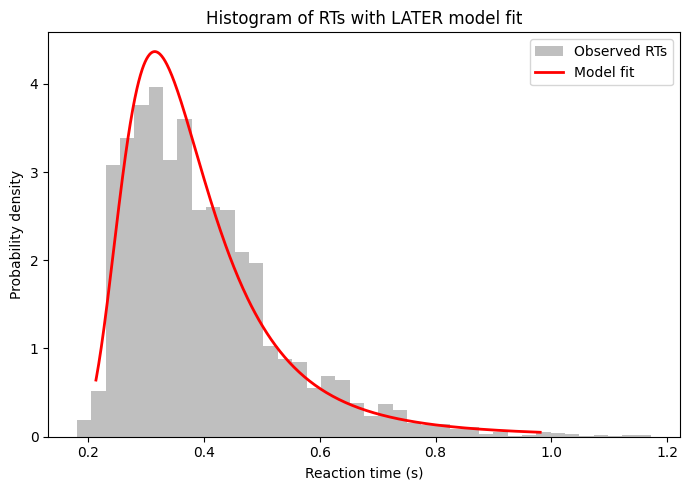

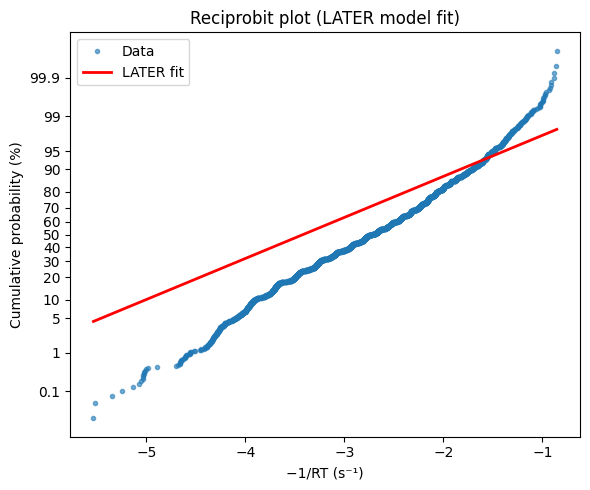

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Assume you already have:
# RTs            = raw reaction times (in seconds)
# best_params    = [muR, deltaS] from your fit

muR, deltaS = best_params
R = 1.0 / RTs  # reciprocal RTs

# 1️⃣  Histogram of RTs + fitted model (transformed back from R-space)
plt.figure(figsize=(7,5))
plt.hist(RTs, bins=40, density=True, alpha=0.5, color='gray', label='Observed RTs')

# model-predicted RT density (via change of variables)
r_vals = np.linspace(np.percentile(R, 0.5), np.percentile(R, 99.5), 400)
pR = norm.pdf(r_vals, muR, deltaS)
# transform p(R) to p(RT): p(RT) = p(R) * |dR/dRT| = p(R)/RT^2
rt_model = 1.0 / r_vals
pRT = pR / (rt_model ** 2)
plt.plot(rt_model, pRT, 'r-', lw=2, label='Model fit')

plt.xlabel("Reaction time (s)")
plt.ylabel("Probability density")
plt.title("Histogram of RTs with LATER model fit")
plt.legend()
plt.tight_layout()
plt.show()

# 2️⃣  Reciprocity–probit (reciprobit) plot
rrt = -1.0 / RTs
rrt = np.sort(rrt)
n = rrt.size
p = (np.arange(1, n+1) - 0.5) / n
z = norm.ppf(p)

plt.figure(figsize=(6,5))
plt.plot(rrt, z, 'o', ms=3, alpha=0.6, label='Data')

# fitted straight line: z = (x + muR/deltaS)*deltaS
xfit = np.linspace(rrt.min(), rrt.max(), 100)
yfit = (xfit + muR/deltaS) * deltaS
plt.plot(xfit, yfit, 'r-', lw=2, label='LATER fit')

# pretty probit axis
ytick_perc = np.array([0.1,1,5,10,20,30,40,50,60,70,80,90,95,99,99.9])
ytick_vals = norm.ppf(ytick_perc/100)
plt.yticks(ytick_vals, [f"{p:g}" for p in ytick_perc])
plt.xlabel("−1/RT (s⁻¹)")
plt.ylabel("Cumulative probability (%)")
plt.title("Reciprobit plot (LATER model fit)")
plt.legend()
plt.tight_layout()
plt.show()